In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from difflib import SequenceMatcher
from IPython.core.display import display, HTML
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
import string
from itertools import product
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

/var/folders/qv/3fzkrr1d7n1d89qsnl0z3vxm0000gn/T/ipykernel_40719/2359417514.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lezhocheck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pl.read_csv('./data/test_dataset.csv')
data.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,i64,str,str,str,str,str,bool,str,str,str
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit"""
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean"""


# First view (general stats)

In [3]:
data.describe()

statistic,address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,str,f64,str,str,str,str,str,f64,str,str,str
"""count""","""3923""",3923.0,"""3923""","""3923""","""550""","""550""","""3923""",3791.0,"""944""","""1004""","""3923"""
"""null_count""","""0""",0.0,"""0""","""0""","""3373""","""3373""","""0""",132.0,"""2979""","""2919""","""0"""
"""mean""",null,8229.403518,null,null,null,null,null,0.250594,null,null,null
"""std""",null,18462.217717,null,null,null,null,null,null,null,null,null
"""min""","""0x0000000000095413afc295d19ede…",1.0,"""0x""","""CALLDATASIZE ISZERO PUSH2 JUMP…","""Cyber""","""Exploit""","""Manual_Validation""",0.0,"""Reviewer1""","""""AvoImportCreditsManager"", par…","""Clean"""
"""25%""",null,1.0,null,null,null,null,null,null,null,null,null
"""50%""",null,1.0,null,null,null,null,null,null,null,null,null
"""75%""",null,137.0,null,null,null,null,null,null,null,null,null
"""max""","""0xffe2519fad60c7ca0c18756392ae…",99999.0,"""0x7fffffffffffffffffffffffffff…","""RETURNDATASIZE RETURNDATASIZE …","""Fraud""","""FinancialScam""","""White_Lists""",1.0,"""Reviewer4""","""whitelist component, shouldn't…","""FinancialScam"""


In [4]:
data.select(pl.all().n_unique())

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
3907,7,3893,3914,3,3,5,3,5,811,3


The number of unique addresses is smaller than the total dataset length, indicating some addresses appear multiple times.

Next Steps:
- Analyze the frequency distribution of repeated addresses to identify patterns.
- Investigate why some addresses appear multiple times.

In [5]:
pl.Config.set_tbl_rows(32)
duplicates = data.filter(data.select(['address']).is_duplicated()).sort('address')
duplicates

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,i64,str,str,str,str,str,bool,str,str,str
"""0x1896adbe708bf91158748b3f3373…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x1896adbe708bf91158748b3f3373…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x23208b91a98c7c1cd9fe63085bff…",43114,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x23208b91a98c7c1cd9fe63085bff…",42161,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x26cfb7ef8fce43c8819b33c02f3d…",1,"""0x6080604052600436106100f1575f…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""Random_Data""",false,null,null,"""Clean"""
"""0x26cfb7ef8fce43c8819b33c02f3d…",42161,"""0x6080604052600436106100f25760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""Random_Data""",false,null,null,"""Clean"""
"""0x2e96068b3d5b5bae3d7515da4a1d…",137,"""0x600436101561000d57611714565b…","""PUSH1 CALLDATASIZE LT ISZERO P…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x2e96068b3d5b5bae3d7515da4a1d…",1,"""0x600436101561000d57612fe0565b…","""PUSH1 CALLDATASIZE LT ISZERO P…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x634322671380cf1ee7bd555a77fc…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""


There are definite duplicate addresses in the dataset, suggesting some addresses appear more than once

Let's study it a bit closer

In [6]:
res = []
for (address,), entries in duplicates.group_by('address'):
    row = entries.select(pl.all().n_unique()).with_columns(
        pl.lit(address).alias('address')
    )
    res.append(row)
res = pl.concat(res)
res

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""0xa489fdc65229d6225014c0b357bc…",1,1,2,1,1,1,1,1,1,1
"""0x9bbdef63594d5ffc2f370fe52115…",2,2,2,1,1,1,1,1,1,1
"""0xc0a47dfe034b400b47bdad5fecda…",1,1,2,1,1,1,1,1,1,1
"""0x1896adbe708bf91158748b3f3373…",1,1,2,1,1,1,1,1,1,1
"""0x23208b91a98c7c1cd9fe63085bff…",2,2,2,1,1,1,1,1,1,1
"""0x9be508ce41ae5795e1ebc247101c…",2,2,2,1,1,1,2,2,2,1
"""0x8ef71fde0681f567d241a2cb7f2a…",2,2,2,1,1,1,1,1,1,1
"""0xdfcdb5a86b167b3a418f3909d6f7…",2,2,2,1,1,1,1,1,1,1
"""0x26cfb7ef8fce43c8819b33c02f3d…",2,2,2,1,1,1,1,1,1,1


So, we have 2 situations with duplicates:

In [7]:
# Situation 1: same adresses, different chain_ids. 
# Possibly it is a redeployment of same contract to different blockchains
duplicates.filter(pl.col('address').str.starts_with('0xb4315e873dbcf96ffd0acd8ea43f'))

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,i64,str,str,str,str,str,bool,str,str,str
"""0xb4315e873dbcf96ffd0acd8ea43f…",43114,"""0x60806040526004361061019a5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0xb4315e873dbcf96ffd0acd8ea43f…",56,"""0x60806040526004361061019a5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean"""


In [8]:
# Situation 2: same chain_ids, same bytecodes, different opcodes. 
# Possibly there is a poblem with algorithm that converts bytecode to opcode.
# We can see that there are some not recognized tokens.
temp = duplicates.filter(pl.col('address').str.starts_with('0x831091da075665168e01898c6dac'))
temp

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,i64,str,str,str,str,str,bool,str,str,str
"""0x831091da075665168e01898c6dac…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""
"""0x831091da075665168e01898c6dac…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean"""


In [9]:
def highlight_differences(line1: str, line2: str) -> tuple[str, str]:
    matcher = SequenceMatcher(None, line1.split(), line2.split())
    highlighted_line1 = []
    highlighted_line2 = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "equal":
            highlighted_line1.append(" ".join(line1.split()[i1:i2]))
            highlighted_line2.append(" ".join(line2.split()[j1:j2]))
        elif tag == "replace" or tag == "delete":
            highlighted_line1.append(f"<span style='background-color: #ffcccc;'>{' '.join(line1.split()[i1:i2])}</span>")
        if tag == "replace" or tag == "insert":
            highlighted_line2.append(f"<span style='background-color: #ccffcc;'>{' '.join(line2.split()[j1:j2])}</span>")
    return ' '.join(highlighted_line1), ' '.join(highlighted_line2)


def display_side_by_side_highlight(long_string1: str, long_string2: str, tokens_per_line: int = 5) -> None:
    tokens1 = long_string1.split()
    tokens2 = long_string2.split()
    lines1 = [' '.join(tokens1[i:i + tokens_per_line]) for i in range(0, len(tokens1), tokens_per_line)]
    lines2 = [' '.join(tokens2[i:i + tokens_per_line]) for i in range(0, len(tokens2), tokens_per_line)]
    max_lines = max(len(lines1), len(lines2))
    lines1 += [''] * (max_lines - len(lines1))
    lines2 += [''] * (max_lines - len(lines2))
    highlighted_lines = [highlight_differences(l1, l2) for l1, l2 in zip(lines1, lines2)]
    table_html = "<table style='border-spacing: 10px;'><tr><th>Code 1</th><th>Code 2</th></tr>"
    for h1, h2 in highlighted_lines:
        table_html += f"<tr><td style='vertical-align: top;'>{h1}</td><td style='vertical-align: top;'>{h2}</td></tr>"
    table_html += "</table>"
    display(HTML(table_html))


display_side_by_side_highlight(temp['opcode'][0], temp['opcode'][1], tokens_per_line=50)

Code 1,Code 2
PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2 JUMPI PUSH1 DUP1 REVERT JUMPDEST POP PUSH1 CALLDATASIZE LT PUSH2 JUMPI PUSH1 CALLDATALOAD PUSH1 SHR DUP1 PUSH4 40c10f19 GT PUSH2 JUMPI DUP1 PUSH4 a457c2d7 GT PUSH2 JUMPI DUP1 PUSH4 ca15c873 GT PUSH2 JUMPI DUP1 PUSH4 ca15c873 EQ PUSH2 JUMPI DUP1 PUSH4 d5391393 EQ,PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2 JUMPI PUSH1 DUP1 REVERT JUMPDEST POP PUSH1 CALLDATASIZE LT PUSH2 JUMPI PUSH1 CALLDATALOAD PUSH1 SHR DUP1 PUSH4 40c10f19 GT PUSH2 JUMPI DUP1 PUSH4 a457c2d7 GT PUSH2 JUMPI DUP1 PUSH4 ca15c873 GT PUSH2 JUMPI DUP1 PUSH4 ca15c873 EQ PUSH2 JUMPI DUP1 PUSH4 d5391393 EQ
PUSH2 JUMPI DUP1 PUSH4 d547741f EQ PUSH2 JUMPI DUP1 PUSH4 dd62ed3e EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 a457c2d7 EQ PUSH2 JUMPI DUP1 PUSH4 a5364c7e EQ PUSH2 JUMPI DUP1 PUSH4 a9059cbb EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 91d14854 GT PUSH2 JUMPI DUP1 PUSH4 91d14854 EQ PUSH2 JUMPI,PUSH2 JUMPI DUP1 PUSH4 d547741f EQ PUSH2 JUMPI DUP1 PUSH4 dd62ed3e EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 a457c2d7 EQ PUSH2 JUMPI DUP1 PUSH4 a5364c7e EQ PUSH2 JUMPI DUP1 PUSH4 a9059cbb EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 91d14854 GT PUSH2 JUMPI DUP1 PUSH4 91d14854 EQ PUSH2 JUMPI
DUP1 PUSH4 95d89b41 EQ PUSH2 JUMPI DUP1 PUSH4 9dc29fac EQ PUSH2 JUMPI DUP1 PUSH4 a217fddf EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 40c10f19 EQ PUSH2 JUMPI DUP1 PUSH4 70a08231 EQ PUSH2 JUMPI DUP1 PUSH4 9010d07c EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 2b014a12 GT PUSH2 JUMPI DUP1 PUSH4,DUP1 PUSH4 95d89b41 EQ PUSH2 JUMPI DUP1 PUSH4 9dc29fac EQ PUSH2 JUMPI DUP1 PUSH4 a217fddf EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 40c10f19 EQ PUSH2 JUMPI DUP1 PUSH4 70a08231 EQ PUSH2 JUMPI DUP1 PUSH4 9010d07c EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 2b014a12 GT PUSH2 JUMPI DUP1 PUSH4
355274ea GT PUSH2 JUMPI DUP1 PUSH4 355274ea EQ PUSH2 JUMPI DUP1 PUSH4 36568abe EQ PUSH2 JUMPI DUP1 PUSH4 38977686 EQ PUSH2 JUMPI DUP1 PUSH4 39509351 EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 2b014a12 EQ PUSH2 JUMPI DUP1 PUSH4 313ce567 EQ PUSH2 JUMPI DUP1 PUSH4 3287581b EQ PUSH2 JUMPI PUSH2,355274ea GT PUSH2 JUMPI DUP1 PUSH4 355274ea EQ PUSH2 JUMPI DUP1 PUSH4 36568abe EQ PUSH2 JUMPI DUP1 PUSH4 38977686 EQ PUSH2 JUMPI DUP1 PUSH4 39509351 EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH4 2b014a12 EQ PUSH2 JUMPI DUP1 PUSH4 313ce567 EQ PUSH2 JUMPI DUP1 PUSH4 3287581b EQ PUSH2 JUMPI PUSH2
JUMP JUMPDEST DUP1 PUSH4 18160ddd GT PUSH2 JUMPI DUP1 PUSH4 18160ddd EQ PUSH2 JUMPI DUP1 PUSH4 23b872dd EQ PUSH2 JUMPI DUP1 PUSH4 248a9ca3 EQ PUSH2 JUMPI DUP1 PUSH4 282c51f3 EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH3 EQ PUSH2 JUMPI DUP1 PUSH4 06fdde03 EQ PUSH2 JUMPI DUP1 PUSH4 095ea7b3 EQ,JUMP JUMPDEST DUP1 PUSH4 18160ddd GT PUSH2 JUMPI DUP1 PUSH4 18160ddd EQ PUSH2 JUMPI DUP1 PUSH4 23b872dd EQ PUSH2 JUMPI DUP1 PUSH4 248a9ca3 EQ PUSH2 JUMPI DUP1 PUSH4 282c51f3 EQ PUSH2 JUMPI PUSH2 JUMP JUMPDEST DUP1 PUSH3 EQ PUSH2 JUMPI DUP1 PUSH4 06fdde03 EQ PUSH2 JUMPI DUP1 PUSH4 095ea7b3 EQ
PUSH2 JUMPI JUMPDEST PUSH1 DUP1 REVERT JUMPDEST PUSH2 PUSH1 DUP1 CALLDATASIZE SUB PUSH1 DUP2 LT ISZERO PUSH2 JUMPI PUSH1 DUP1 REVERT JUMPDEST POP CALLDATALOAD PUSH1 PUSH1 PUSH1 SHL SUB AND PUSH2 JUMP JUMPDEST STOP JUMPDEST PUSH2 PUSH2 JUMP JUMPDEST PUSH1 DUP1 MLOAD PUSH1 DUP1 DUP3 MSTORE DUP4 MLOAD DUP2 DUP4,PUSH2 JUMPI JUMPDEST PUSH1 DUP1 REVERT JUMPDEST PUSH2 PUSH1 DUP1 CALLDATASIZE SUB PUSH1 DUP2 LT ISZERO PUSH2 JUMPI PUSH1 DUP1 REVERT JUMPDEST POP CALLDATALOAD PUSH1 PUSH1 PUSH1 SHL SUB AND PUSH2 JUMP JUMPDEST STOP JUMPDEST PUSH2 PUSH2 JUMP JUMPDEST PUSH1 DUP1 MLOAD PUSH1 DUP1 DUP3 MSTORE DUP4 MLOAD DUP2 DUP4
ADD MSTORE DUP4 MLOAD SWAP2 SWAP3 DUP4 SWAP3 SWAP1 DUP4 ADD SWAP2 DUP6 ADD SWAP1 DUP1 DUP4 DUP4 PUSH1 JUMPDEST DUP4 DUP2 LT ISZERO PUSH2 JUMPI DUP2 DUP2 ADD MLOAD DUP4 DUP3 ADD MSTORE PUSH1 ADD PUSH2 JUMP JUMPDEST POP POP POP POP SWAP1 POP SWAP1 DUP2 ADD SWAP1 PUSH1,ADD MSTORE DUP4 MLOAD SWAP2 SWAP3 DUP4 SWAP3 SWAP1 DUP4 ADD SWAP2 DUP6 ADD SWAP1 DUP1 DUP4 DUP4 PUSH1 JUMPDEST DUP4 D

- It may be necessary to remove opcodes with incorrectly transcribed code from the training pipeline.
- Another approach could be to identify where this occurred and attempt to recalculate the correct values.

In [10]:
# Let's see different opcodes which have same bytecode
data.with_columns(
    pl.col('opcode').n_unique().over('bytecode').alias('un')
).filter(pl.col('un') > 1).sort('bytecode')

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,un
str,i64,str,str,str,str,str,bool,str,str,str,u32
"""0xc06057222d5f2c8e8c80d817b1e7…",1,"""0x""","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""Manual_Validation""",true,"""Reviewer2""","""Withdraw, self destruct""","""Clean""",20
"""0x398c8fb15120ef0f795e32cb1388…",137,"""0x""","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""",20
"""0x463f9ed5e11764eb9029762011a0…",1,"""0x""","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",20
"""0xfb0d751c0dc8bf7b0d1da4b6b9a5…",1,"""0x""","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""Random_Data""",false,null,null,"""Clean""",20
"""0x1246542e895f81ac2fd53b7dbe01…",56,"""0x""","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Manual_Validation""",true,"""Reviewer1""","""helper/tool, transfers tokens""","""Clean""",20
"""0xc446e0a1e22b54e18303022ff8c5…",1,"""0x""","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",null,null,"""rekt_db Nft Trader Reentrancy …","""Exploit""",20
"""0x76ce14947f74a2664700e68452fe…",1,"""0x""","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",20
"""0x5882f3b6c0d6490668f907a4313e…",43114,"""0x""","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Manual_Validation""",true,"""Reviewer1""","""executes static functions on a…","""Clean""",20
"""0x0a6f564c5c9bebd66f1595f1b51d…",1,"""0x""","""PUSH1 PUSH1 MSTORE CALLDATASIZ…",null,null,"""White_Lists""",false,null,null,"""Clean""",20


- We have some identical bytecodes associated with different opcodes, which is unusual since, as stated in the task description, opcodes are derived from bytecodes. This suggests potential issues with the derivation process.
- As stated earlier, it was identified two types of problems:
    - Some contracts have a “0x” bytecode but different opcodes. This problem might result from errors in data processing or issues when receiving data from the sources.
	- Certain bytecodes have recognition or interpretation issues. For example, there is a tail with “c7 (Unknown Opcode) STOP c7 (Unknown Opcode)…”.
- Opcodes with such issues should likely be removed from the dataset, as in most cases, duplicates with corrected data exist. However, I will not remove them for now. This issue should be further discussed and investigated to identify the root cause of the duplicates.

shape: (3, 2)
┌───────────────┬────────────┐
│ label         ┆ proportion │
│ ---           ┆ ---        │
│ str           ┆ f64        │
╞═══════════════╪════════════╡
│ Exploit       ┆ 0.088963   │
│ Clean         ┆ 0.860056   │
│ FinancialScam ┆ 0.050981   │
└───────────────┴────────────┘


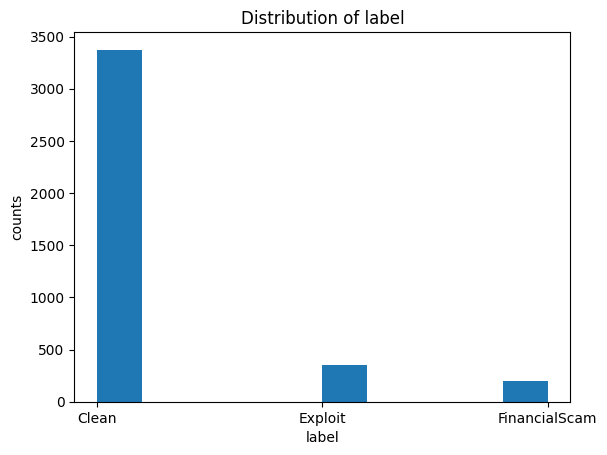

In [11]:
# Now let's visualize some distributions

print(data['label'].value_counts(normalize=True))
plt.hist(data['label'])
plt.title('Distribution of label')
plt.xlabel('label')
plt.ylabel('counts')
plt.show()

- There is an obvious class imbalance in the dataset.
-	This could pose a problem during training, so it needs to be addressed.
-	One approach is to use different class weights when training the model.
-	Another idea is to combine the Exploit and Financial Scam labels into a single “malicious” category to train the model for detecting malicious activity as a whole. This strategy may improve results by allowing the model to share knowledge between these “bad” classes.
-	If separate categories are required, we can train a multiclass model or apply an additional classifier afterward.

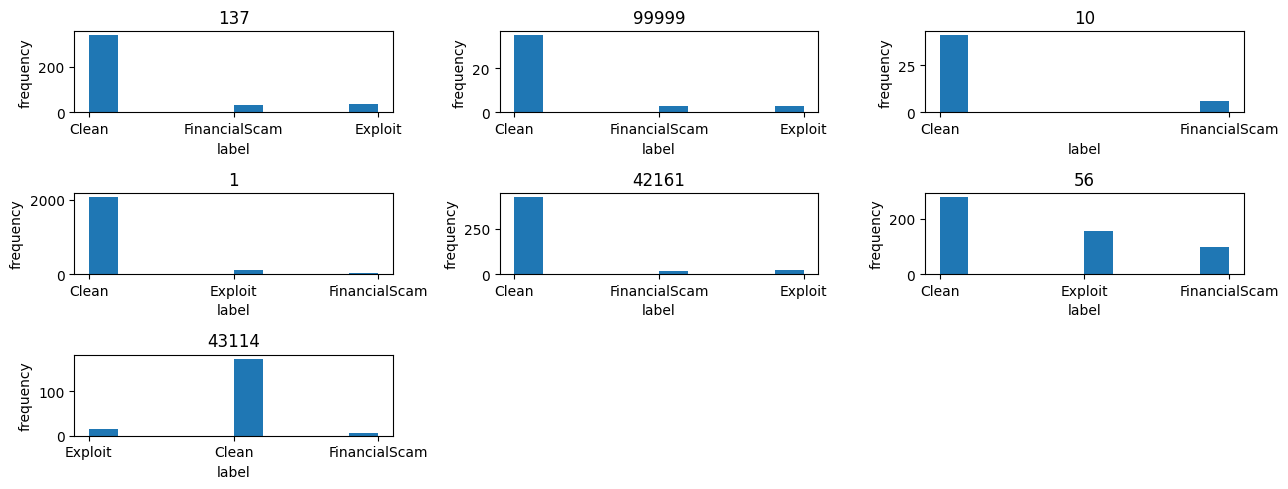

In [12]:
def hist_over_cat(column: str, category: str):
    total_graphs = data[category].n_unique()
    x_s, y_s = int(np.ceil(total_graphs**0.5)), total_graphs // int(total_graphs**0.5)
    fig, axs = plt.subplots(x_s, y_s, figsize=(13, 5))
    for ((chain_id,), sample), ax in zip(data.group_by(category), axs.flatten()):
        ax.hist(sample[column])
        ax.set_title(chain_id)
        ax.set_xlabel(column)
        ax.set_ylabel('frequency')
    for ax in axs.flatten():
        if not ax.has_data():
           fig.delaxes(ax) 
    plt.tight_layout()
    plt.show()

hist_over_cat('label', category='chain_id')

- Some blockchains tend to have more exploit/scam labels, possibly due to internal policies or inherent vulnerabilities.
- For instance, blockchain 56 shows significantly more exploits and scams compared to others.
- On the other hand, blockchain 10 has no exploit labels at all, which could indicate either insufficient data collection or a higher level of security.

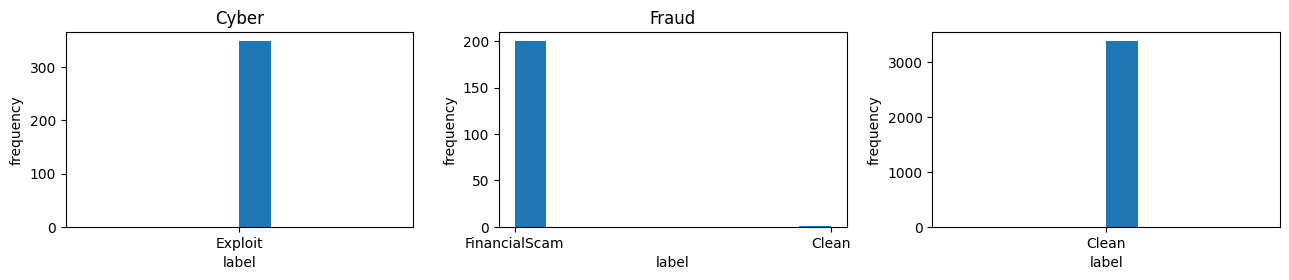

In [13]:
hist_over_cat('label', category='malicious_category_l1')

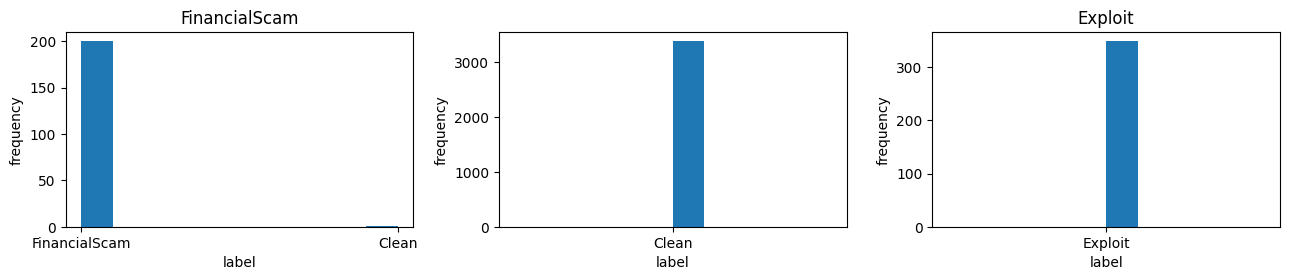

In [14]:
hist_over_cat('label', category='malicious_category_l2')

- The malicious_category feature appears to separate labels effectively. This suggests that labels may be derived, at least partially, from malicious_category_l1 and malicious_category_l2.
- However, there are some Clean entries within FinancialScam (malicious_category_l2) and Fraud (malicious_category_l1). This could indicate potential labeling issues during category assignment, which are later corrected (an assumption).
- Additionally, malicious_category_l1 and malicious_category_l2 cannot be directly used as features in the training dataset with the target label, as this would cause data leakage. However, they might be leveraged in a more sophisticated way to enhance the model.

In [15]:
# Let's see the contracts that have some malicious_category and clean label
data.filter(
    (pl.col('malicious_category_l1') == 'Fraud') | (pl.col('malicious_category_l2') == 'FinancialScam'),
    pl.col('label') == 'Clean'
)

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label
str,i64,str,str,str,str,str,bool,str,str,str
"""0x71f57929a3c4387dc9573413059a…",56,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…","""Fraud""","""FinancialScam""","""Public_Historical_Data""",null,null,"""reported by HashDit, ponzi""","""Clean"""


- There is one problematic contract: it is marked as malicious, but its label is Clean. Additionally, it has not been manually validated.
- This suggests a potential misassignment of either the label or the category, which requires further investigation.

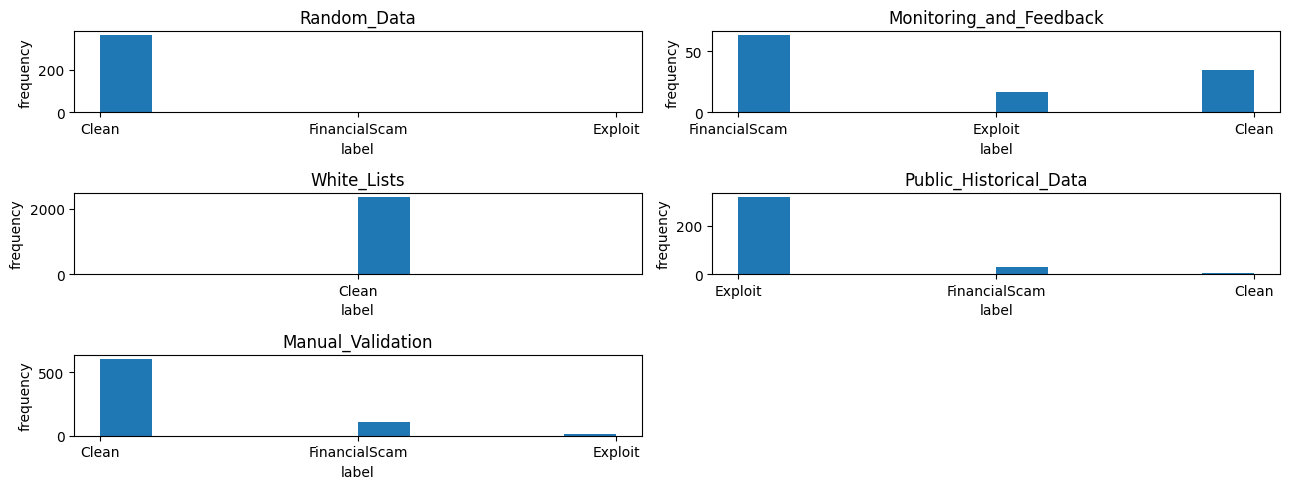

In [16]:
hist_over_cat('label', category='data_source')

- Some sources, such as white_lists and random_data, contain only Clean labels.
- This indicates that the data_source feature is informative and could be valuable for the model.

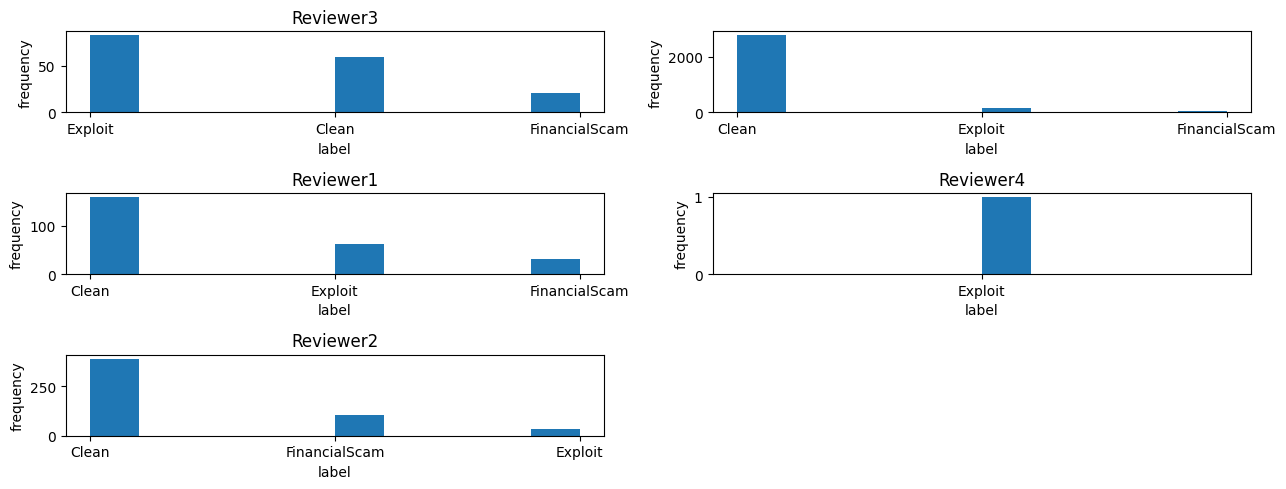

In [17]:
hist_over_cat('label', category='man_validated_by')

- Reviewer1 and Reviewer2 heavily skew toward Clean, while Reviewer4 exclusively labels Exploit, suggesting potential biases or specialization. 
- Reviewer3 has the most balanced labeling across categories. 
- These patterns highlight the need to address class imbalance and investigate reviewer-specific labeling criteria.

In [18]:
data.select(
    pl.col('man_validated').cast(pl.Int16),
    'chain_id',
    (pl.col('label') != 'Clean').cast(pl.Int16)
).drop_nulls().corr()

man_validated,chain_id,label
f64,f64,f64
1.0,0.193316,0.421523
0.193316,1.0,-0.038254
0.421523,-0.038254,1.0


<Axes: >

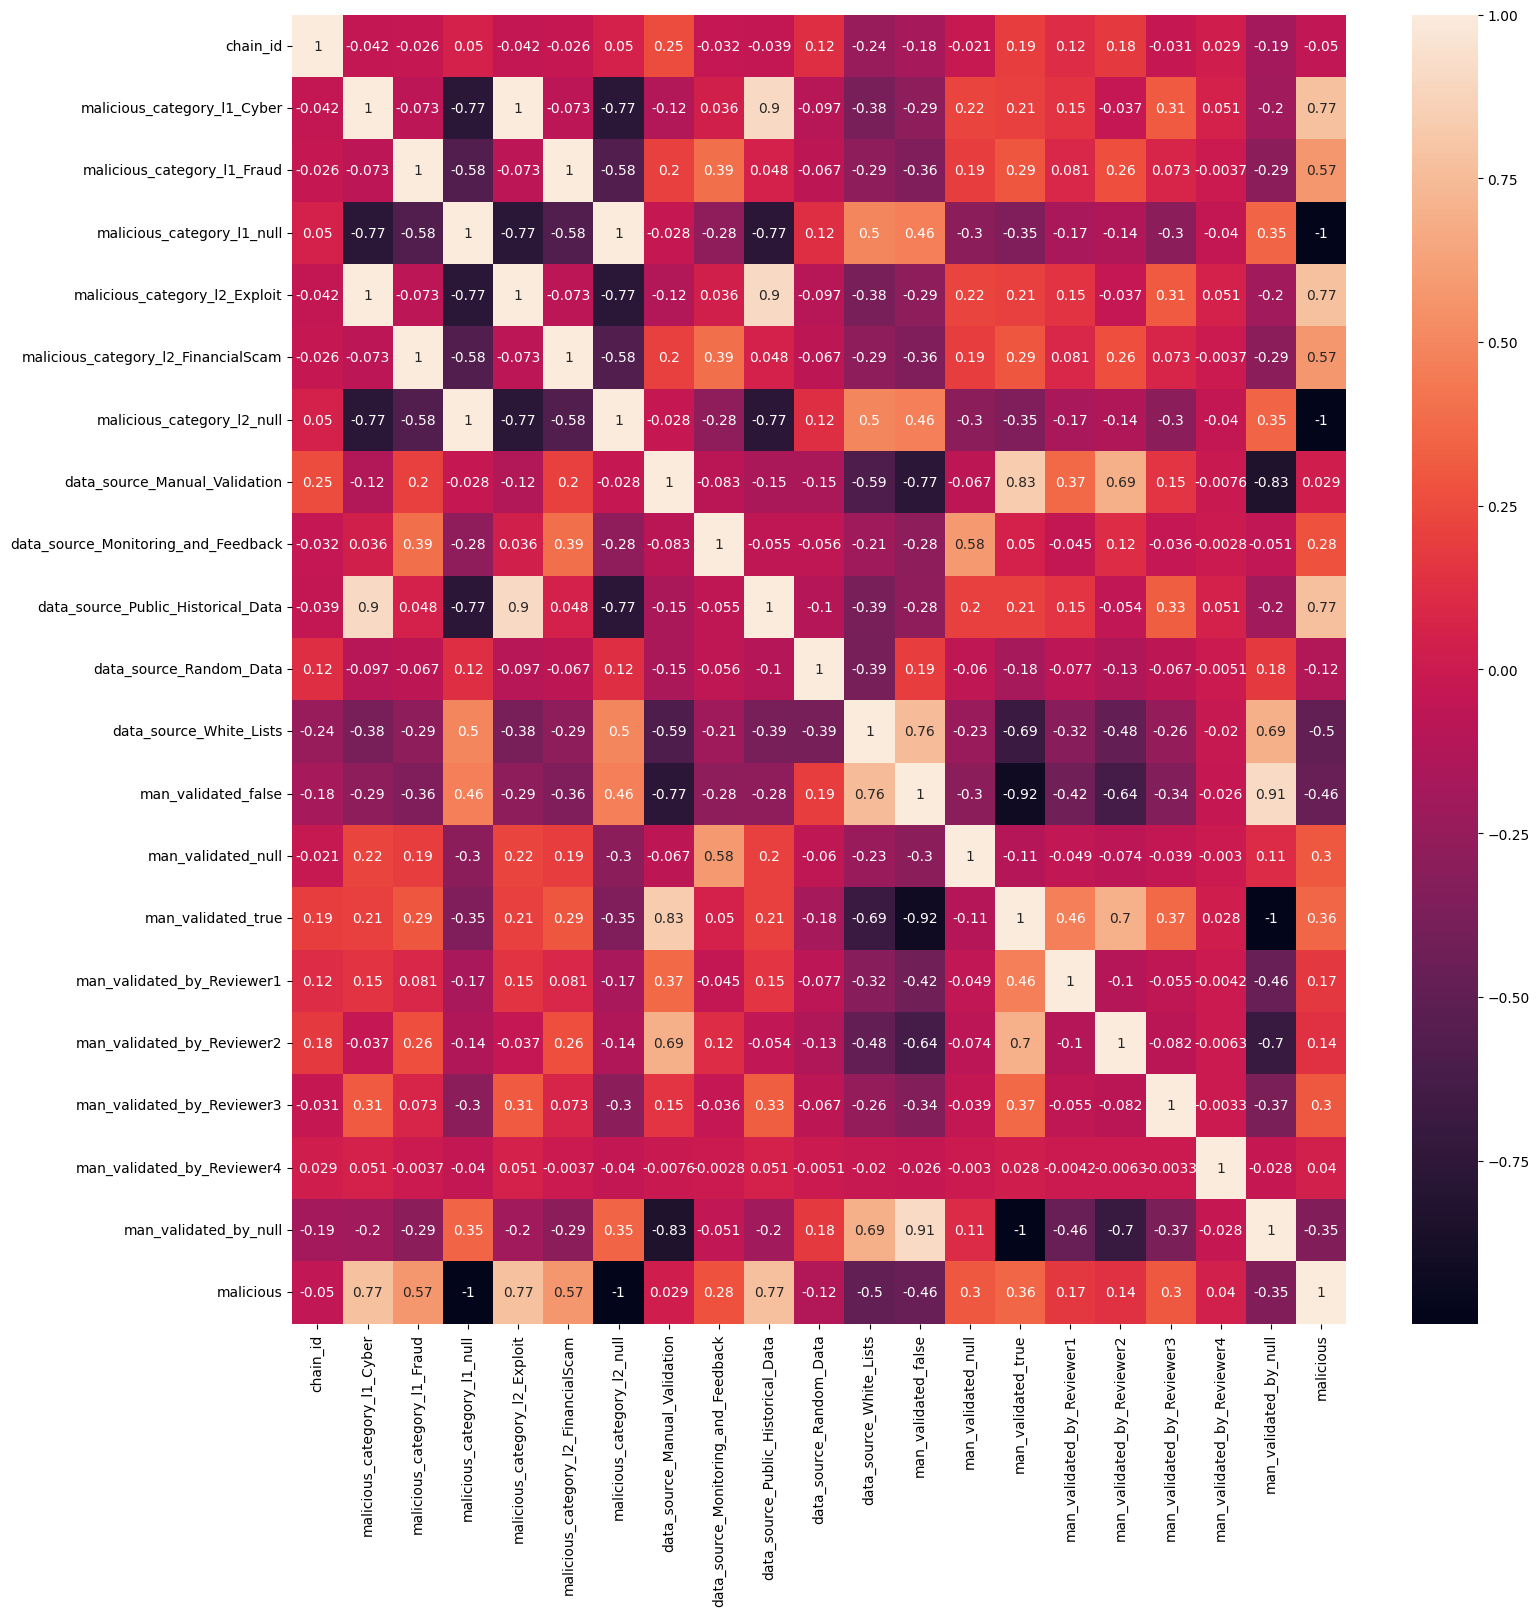

In [19]:
plot_data = data.select(
    'chain_id', 
    'malicious_category_l1', 
    'malicious_category_l2', 'data_source', 
    'man_validated', 'man_validated_by',
    (pl.col('label') != 'Clean').cast(pl.Int16)
).to_dummies([
    'malicious_category_l1', 
    'malicious_category_l2', 'data_source', 
    'man_validated', 'man_validated_by'
]).rename({'label': 'malicious'})

plt.subplots(figsize=(17,17))
sns.heatmap(plot_data.to_pandas().corr(), annot=True)

- chain_id: Shows some correlation with the label, indicating minimal overall influence, but certain chains are more associated with malicious contracts (as stated before).
- malicious_category_l1 and malicious_category_l2: Highly correlated with the target, as previously explained.
- data_source:
	- Public historical data is highly predictive.
	- White lists strongly correlate with non-malicious contracts (expected due to their nature).
	- Random data is less predictive compared to other sources.
-	man_validated: Strong correlation with malicious labels, as most validated contracts were malicious (as seen earlier).
- man_validated_by: Shows good correlation, indicating reviewer ID has a notable impact on the target.

In [20]:
# Let's see how many not-null comments we have
data.group_by('label').agg(
    pl.col('comment').is_not_null().mean()
)

label,comment
str,f64
"""FinancialScam""",0.92
"""Clean""",0.182276
"""Exploit""",0.587393


In [21]:
data.select('comment', 'label').drop_nulls().filter(pl.col('label') !='Clean')

comment,label
str,str
"""Data additionally gathered fro…","""Exploit"""
"""Balancer Exploiter""","""Exploit"""
"""Rugpull, owner used ""backdoor""…","""FinancialScam"""
"""Hedgey Finance's exploit""","""Exploit"""
"""Looks scammy""","""FinancialScam"""
"""Token sale scam""","""FinancialScam"""
"""DND exploit""","""Exploit"""
"""Seems malicious""","""FinancialScam"""
"""panda token, created by other …","""FinancialScam"""


- To process comments, we can use several strategies:
    - Analyze text length, comment sentiment, or extract key keywords.
    - Apply embeddings like BERT or Word2Vec, preceded by stop-word removal and text preprocessing.
- I will provide a small example, but for production, a more thorough analysis is required.

In [22]:
# Let's calculate comment embeddings 

comments_to_feed = data.with_row_index().select(
    'index', 'comment'
).filter(pl.col('comment').is_not_null())
comments_to_feed.head()

index,comment
u32,str
3,"""Data additionally gathered fro…"
17,"""Trade bot"""
21,"""Tries to mint something then t…"
23,"""Balancer Exploiter"""
24,"""Rugpull, owner used ""backdoor""…"


In [23]:
stop_words = set(stopwords.words("english"))


def preprocess(text: str) -> str:
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [24]:
comments_to_feed = comments_to_feed.with_columns(
    pl.col('comment').map_elements(preprocess, return_dtype=pl.String).alias('comment_prep')
)
comments_to_feed.head()

index,comment,comment_prep
u32,str,str
3,"""Data additionally gathered fro…","""data additionally gathered rek…"
17,"""Trade bot""","""trade bot"""
21,"""Tries to mint something then t…","""tries mint something transfer"""
23,"""Balancer Exploiter""","""balancer exploiter"""
24,"""Rugpull, owner used ""backdoor""…","""rugpull owner used backdoor fu…"


In [25]:
from transformers import AutoTokenizer, AutoModel
import torch


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


def get_sentence_embedding(sentence: str) -> np.array:
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()


embeddings = [get_sentence_embedding(sentence) for sentence in comments_to_feed['comment_prep']]

In [26]:
comments_to_feed = comments_to_feed.with_columns(
    pl.Series(name='comment_embedding', values=[e.tolist() for e in embeddings])
)
comments_to_feed.head()

index,comment,comment_prep,comment_embedding
u32,str,str,list[f64]
3,"""Data additionally gathered fro…","""data additionally gathered rek…","[-0.106108, -0.001316, … 0.343234]"
17,"""Trade bot""","""trade bot""","[-0.519999, 0.240356, … 0.782469]"
21,"""Tries to mint something then t…","""tries mint something transfer""","[-0.05005, 0.288958, … 0.458887]"
23,"""Balancer Exploiter""","""balancer exploiter""","[-0.417593, -0.293309, … 0.55728]"
24,"""Rugpull, owner used ""backdoor""…","""rugpull owner used backdoor fu…","[-0.568428, -0.214362, … 0.538816]"


In [27]:
data_processed = data.with_row_index().join(
    comments_to_feed.select('index', 'comment_embedding'), 
    on='index', how='left'
).drop('index')
data_processed.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,comment_embedding
str,i64,str,str,str,str,str,bool,str,str,str,list[f64]
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""","[-0.106108, -0.001316, … 0.343234]"
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""",null


In [28]:
cos_d = dict()
for (label,), df in data_processed.group_by('label'):
    res = np.mean(df['comment_embedding'].drop_nulls().to_numpy(), axis=0)
    cos_d[label] = res

In [29]:
for comb in product(cos_d, cos_d):
    print(comb, cosine(cos_d[comb[0]], cos_d[comb[1]]))

('Exploit', 'Exploit') 0.0
('Exploit', 'Clean') 0.013666606843415585
('Exploit', 'FinancialScam') 0.01718908673458852
('Clean', 'Exploit') 0.013666606843415585
('Clean', 'Clean') 0.0
('Clean', 'FinancialScam') 0.00821918621448825
('FinancialScam', 'Exploit') 0.01718908673458852
('FinancialScam', 'Clean') 0.00821918621448825
('FinancialScam', 'FinancialScam') 0.0


- Exploit is more distinct from FinancialScam (distance = 0.017) and Clean (distance = 0.0137).
- FinancialScam and Clean share some linguistic similarity (distance = 0.0082), suggesting potential overlap in language or context.
- Comment embeddings capture meaningful distinctions between groups, making them valuable for label prediction.
- This is a basic example to demonstrate ideas for working with comments. Ideally, sentiment analysis should be performed to better understand how comments relate to scams.

In [30]:
# For now, comment embeddings can be used as features by calculating the mean embedding, which is the simplest approach
# In a production, more advanced features, such as comment sentiment analysis, should be computed for better results

data_processed = data_processed.with_columns(
    pl.col('comment_embedding').list.mean()
)
data_processed.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,comment_embedding
str,i64,str,str,str,str,str,bool,str,str,str,f64
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",null
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""",-0.008201
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""",null


# Working with smart contract code

Now, let’s generate features from the code by analyzing the different tokens (opcodes).

In [31]:
from collections import defaultdict
op_dict = defaultdict(int)

for code in data['opcode'].str.split(' '):
    op, count = np.unique(code, return_counts=True)
    for o, c in zip(op.tolist(), count.tolist()): op_dict[o] += c

op_df = pl.DataFrame({'command': op_dict.keys(), 'count': op_dict.values()})

In [32]:
# Here are top 10 commands among all smart contracts
op_df = op_df.sort('count', descending=True)
op_df.head(10)

command,count
str,i64
"""PUSH1""",2894719
"""PUSH2""",1667010
"""JUMPDEST""",1104249
"""POP""",1077113
"""SWAP1""",974557
"""ADD""",910959
"""DUP1""",867000
"""DUP2""",844746
"""JUMP""",745135


- Now, we can calculate statistics for the top opcodes, which could serve as valuable features.
- I will provide an example to demonstrate how this can be done.

In [33]:
top_commands = op_df['command'].head(20).to_list()
top_commands

['PUSH1',
 'PUSH2',
 'JUMPDEST',
 'POP',
 'SWAP1',
 'ADD',
 'DUP1',
 'DUP2',
 'JUMP',
 'MSTORE',
 'DUP3',
 'JUMPI',
 'MLOAD',
 'SWAP2',
 'AND',
 'ISZERO',
 'SUB',
 'DUP4',
 'SHL',
 'REVERT']

In [34]:
data_with_counts = data.with_columns(
    pl.col('opcode').str.count_matches(command).alias(f'count_{command}')
    for command in top_commands
)
data_with_counts.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,count_PUSH1,count_PUSH2,count_JUMPDEST,count_POP,count_SWAP1,count_ADD,count_DUP1,count_DUP2,count_JUMP,count_MSTORE,count_DUP3,count_JUMPI,count_MLOAD,count_SWAP2,count_AND,count_ISZERO,count_SUB,count_DUP4,count_SHL,count_REVERT
str,i64,str,str,str,str,str,bool,str,str,str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""",2017,771,588,511,531,410,827,510,1269,352,254,477,304,219,247,441,291,128,257,292
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",622,458,286,219,149,106,184,177,658,67,89,159,78,75,125,78,111,50,88,42
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",2622,1293,767,787,965,831,698,812,1669,738,429,341,433,397,352,241,279,273,329,127
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""",1377,1173,588,784,764,421,512,442,1177,168,243,233,222,195,392,260,95,159,56,151
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""",1002,1289,833,778,569,414,301,415,1670,223,279,201,163,275,207,84,132,149,5,49


<Axes: >

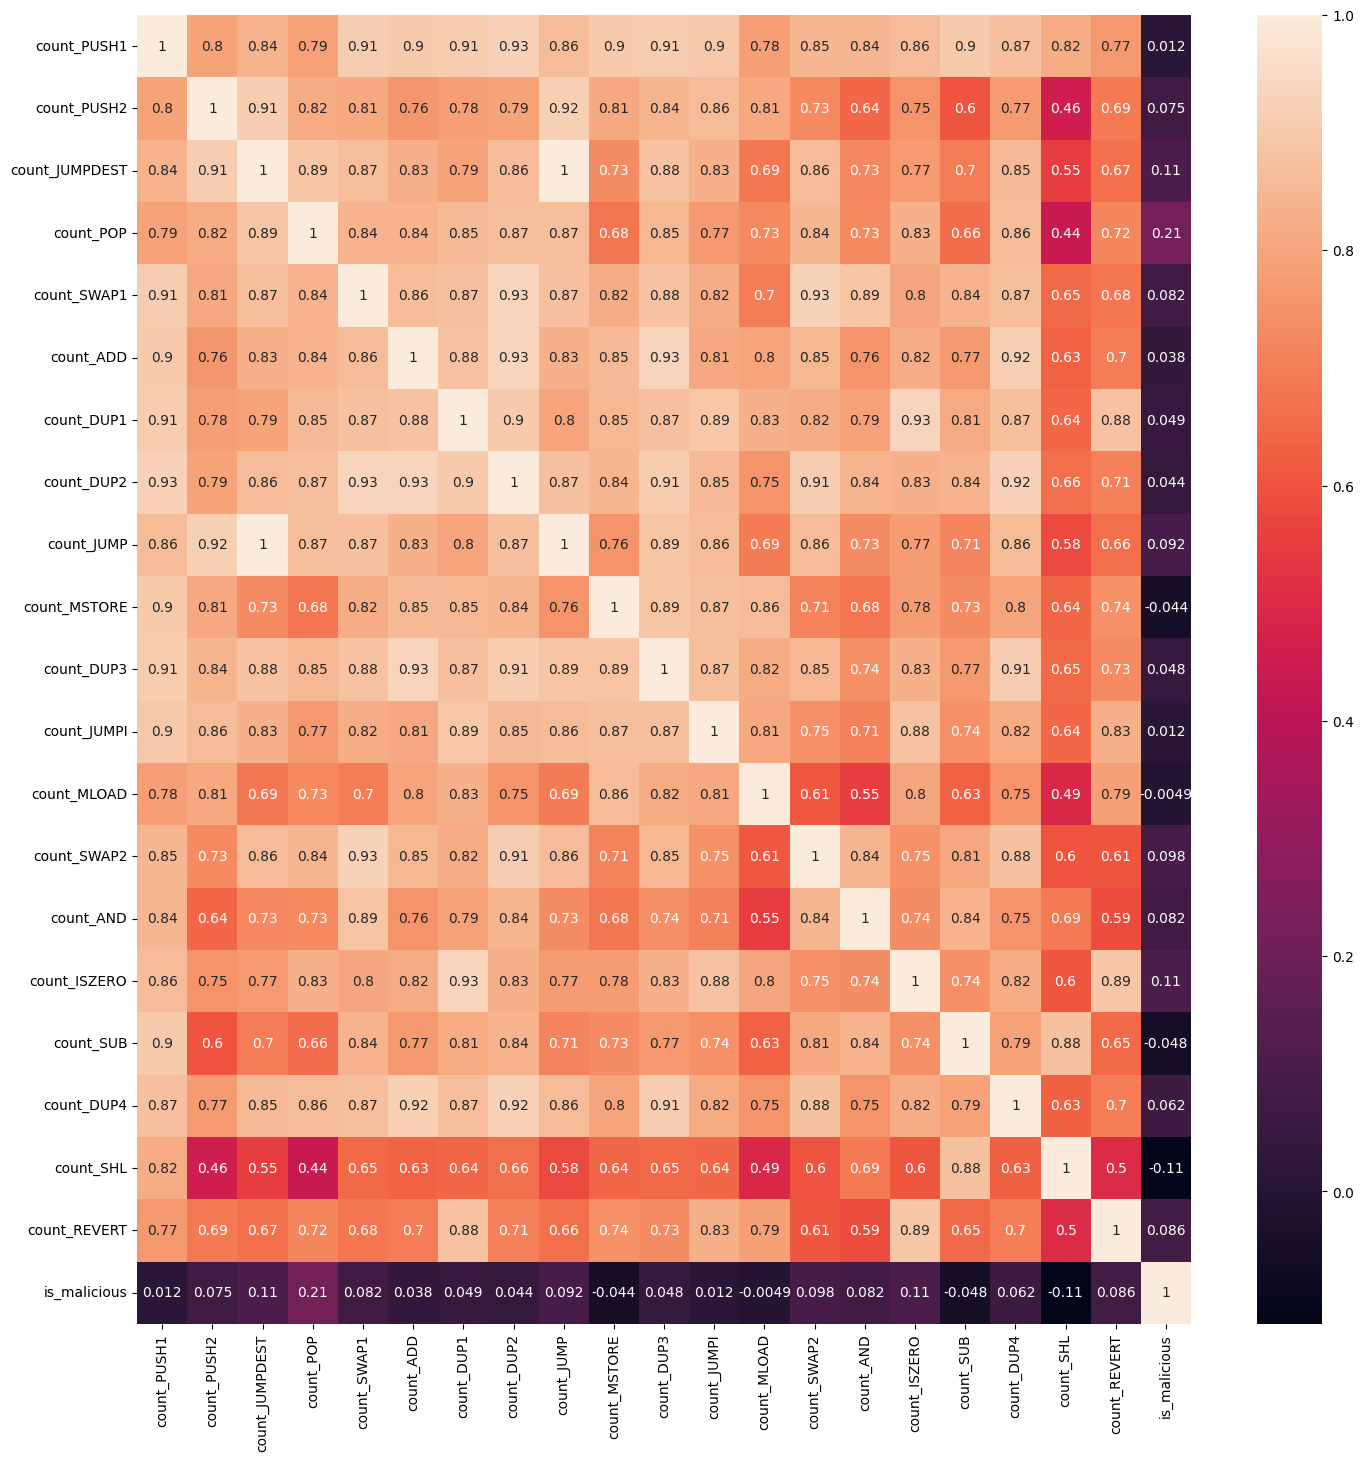

In [35]:
plot_data = data_with_counts.select(pl.selectors.starts_with('count_'), 'label').with_columns(
    (pl.col('label') != 'Clean').cast(pl.Int16)
).rename({'label': 'is_malicious'})

plt.subplots(figsize=(17, 17))
sns.heatmap(plot_data.to_pandas().corr(), annot=True)

- As we can see these features appear promising for predicting malicious contracts.
- For instance, count_POP shows some correlation with malicious contracts. While these features may not be exceptionally strong predictors individually, they carry semantic meaning and describe the code effectively. Experimenting further with similar calculations could yield valuable insights.
- Additional analysis could involve experimenting with different tokens or combinations of tokens. For example, calculating the rarest tokens and creating features to indicate their presence in a contract.
- The count_POP feature demonstrates that this approach has potential, but further research and development will require additional time and effort.

To expand on the previous idea, let’s analyze whether malicious contracts differ from clean ones in terms of the usage of various tokens. This could provide further insights and enhance the feature generation process by identifying specific patterns or trends in token usage that distinguish malicious from clean contracts.

In [36]:
# Now let's try to see wheater it is some difference in specific token usage between clean and malicious code

opcode_stats = data.select('opcode', 'label').with_columns(
    (pl.col('label') != 'Clean').alias('not_clean'),
    pl.col('opcode').str.split(' ')
)
opcode_stats = opcode_stats.explode('opcode')
opcode_stats = opcode_stats.group_by('opcode', 'not_clean').agg(
    pl.len().alias('count')
)
opcode_stats.head()

opcode,not_clean,count
str,bool,u32
"""ecd2b552""",false,1
"""a90101fb""",false,2
"""df52d05d""",false,1
"""74206265656e20696e697469616c69…",false,3
"""ee35ba50""",false,4


In [37]:
clean_stats = (
    opcode_stats
    .filter(pl.col('not_clean') == False)
    .sort('count', descending=True)
    .with_columns(
        pl.col('count').rank('dense', descending=True).cast(pl.Int64).alias('rank_clean')
    )
    .drop('not_clean')
)
not_clean_stats = (
    opcode_stats
    .filter(pl.col('not_clean') == True)
    .sort('count', descending=True)
    .with_columns(
        pl.col('count').rank('dense', descending=True).cast(pl.Int64).alias('rank_malicious')
    )
    .drop('not_clean')
)
merged = clean_stats.join(not_clean_stats, on='opcode', how='inner', suffix='_malicious').with_columns(
    (pl.col('rank_clean') - pl.col('rank_malicious')).alias('rank_diff')
)

merged = merged.filter(pl.col('rank_diff') > 0).sort(pl.col('rank_diff').abs(), descending=True)
merged

opcode,count,rank_clean,count_malicious,rank_malicious,rank_diff
str,u32,i64,u32,i64,i64
"""ba12222222228d8ba445958a75a070…",39,360,309,100,260
"""55d398326f99059ff7754852469990…",24,375,120,132,243
"""f6c00927""",5,394,65,152,242
"""ab9c4b5d""",11,388,74,148,240
"""0abe9688""",2,397,57,159,238
"""10ed43c718714eb63d5aa57b78b547…",19,380,84,143,237
"""dbe65edc""",7,392,59,157,235
"""d0a494e4""",1,398,53,163,235
"""5fc483c50000000000000000000000…",3,396,52,164,232


In [38]:
merged.filter(pl.col('opcode').str.len_chars() < 8).head(30)

opcode,count,rank_clean,count_malicious,rank_malicious,rank_diff
str,u32,i64,u32,i64,i64
"""LOG0""",6,393,2,212,181
"""BASEFEE""",6,393,2,212,181
"""MSIZE""",9,390,1,213,177
"""CREATE2""",46,353,10,204,149
"""PUSH30""",40,359,1,213,146
"""CREATE""",115,290,73,149,141
"""BALANCE""",171,253,102,137,116
"""SMOD""",82,317,2,212,105
"""ORIGIN""",321,192,562,88,104


- Malicious contracts exhibit higher frequencies of certain tokens compared to clean contracts, such as "BALANCE", "BASEFEE", "ORIGIN", "CALL", and "GAS".
- The idea is to identify tokens that are more common in malicious contracts and use them to calculate additional word-count features.
- These features could enhance model performance and improve the prediction of malicious categories.

In [39]:
# Here, I demonstrate an example of these features as a proof of concept
# In a production implementation, additional tokens should be included to enrich the feature set
suspicious_tokens = ['BALANCE', 'BASEFEE', 'ORIGIN', 'GAS', 'CALL'] 
                                                        
data_with_counts = data_with_counts.with_columns(
    pl.col('opcode').str.count_matches(token).alias(f'susp_count_{token}')
    for token in suspicious_tokens
)
data_with_counts.head()


address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,count_PUSH1,count_PUSH2,count_JUMPDEST,count_POP,count_SWAP1,count_ADD,count_DUP1,count_DUP2,count_JUMP,count_MSTORE,count_DUP3,count_JUMPI,count_MLOAD,count_SWAP2,count_AND,count_ISZERO,count_SUB,count_DUP4,count_SHL,count_REVERT,susp_count_BALANCE,susp_count_BASEFEE,susp_count_ORIGIN,susp_count_GAS,susp_count_CALL
str,i64,str,str,str,str,str,bool,str,str,str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""",2017,771,588,511,531,410,827,510,1269,352,254,477,304,219,247,441,291,128,257,292,0,0,0,43,217
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",622,458,286,219,149,106,184,177,658,67,89,159,78,75,125,78,111,50,88,42,0,0,0,10,15
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""",2622,1293,767,787,965,831,698,812,1669,738,429,341,433,397,352,241,279,273,329,127,0,0,0,34,154
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""",1377,1173,588,784,764,421,512,442,1177,168,243,233,222,195,392,260,95,159,56,151,4,0,0,55,101
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""",1002,1289,833,778,569,414,301,415,1670,223,279,201,163,275,207,84,132,149,5,49,0,0,0,2,85


In [40]:
data_with_counts.select(
    pl.selectors.starts_with('susp_count_'), 
    (pl.col('label') != 'Clean').cast(pl.Int16).alias('is_malicious')
).corr()

susp_count_BALANCE,susp_count_BASEFEE,susp_count_ORIGIN,susp_count_GAS,susp_count_CALL,is_malicious
f64,f64,f64,f64,f64,f64
1.0,0.00841,0.202186,0.258005,0.235213,0.239669
0.00841,1.0,0.015444,0.032518,0.062982,0.012824
0.202186,0.015444,1.0,0.23425,0.102569,0.307754
0.258005,0.032518,0.23425,1.0,0.597097,0.219604
0.235213,0.062982,0.102569,0.597097,1.0,0.049452
0.239669,0.012824,0.307754,0.219604,0.049452,1.0


- The features susp_count_BALANCE, susp_count_ORIGIN, and susp_count_GAS show strong correlations with predicting malicious contracts.
- This demonstrates that the proposed idea is effective, and many similar features can be created to describe contracts and improve the model’s ability to recognize malicious activity.

- Next, I propose exploring entropy as a feature for both bytecode and opcode to analyze code more effectively.
- Entropy measures the randomness or unpredictability in a sequence, which could help identify patterns in the code’s structure or behavior.

In [41]:
def calculate_entropy(code: str | pl.Series) -> float:
    arr = np.frombuffer(code.encode('utf-8'), dtype='S1') if isinstance(code, str) else np.array(code)
    _, counts = np.unique(arr, return_counts=True)
    probas = counts / counts.sum()
    return -np.sum(probas * np.log2(probas))

In [42]:
entropy_features = data.with_columns(
    pl.col('bytecode').str.len_chars().alias('bytecode_len'),
    pl.col('bytecode').map_elements(calculate_entropy, return_dtype=pl.Float64).alias('bytecode_entropy'),
    pl.col('bytecode').str.count_matches(r'00').alias('zero_opcode_count'),

    pl.col('opcode').str.split(' '),
).with_columns(
    pl.col('opcode').list.len().alias('opcode_len'),
    pl.col('opcode').map_elements(calculate_entropy, return_dtype=pl.Float64).alias('opcode_diversity'),
)
entropy_features

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,bytecode_len,bytecode_entropy,zero_opcode_count,opcode_len,opcode_diversity
str,i64,str,list[str],str,str,str,bool,str,str,str,u32,f64,u32,u32,f64
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""White_Lists""",false,null,null,"""Clean""",34542,3.526406,1267,11659,4.933656
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""White_Lists""",false,null,null,"""Clean""",14528,3.366208,1235,4161,4.942886
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""White_Lists""",false,null,null,"""Clean""",46826,3.475979,1642,15988,4.9074
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","[""PUSH1"", ""PUSH1"", … ""JUMP""]","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""",39794,3.201832,1163,10603,4.90505
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""Random_Data""",false,null,null,"""Clean""",37652,3.347904,2080,9486,4.777422
"""0xc8ec8deec2483e17b54534b02680…",56,"""0x6080604052348015610010576000…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""Random_Data""",false,null,null,"""Clean""",17076,3.513594,650,5236,4.84908
"""0x094d12e5b541784701fd8d65f11f…",1,"""0x341561000a57600080fd5b600436…","[""CALLVALUE"", ""ISZERO"", … ""REVERT""]",null,null,"""White_Lists""",false,null,null,"""Clean""",12458,3.257891,698,3918,4.354571
"""0x0ccf53bc6354889682020bbd2c44…",1,"""0x3d3d3d3d363d3d3761010a603736…","[""RETURNDATASIZE"", ""RETURNDATASIZE"", … ""RETURN""]",null,null,"""White_Lists""",false,null,null,"""Clean""",644,2.280096,198,30,3.664084
"""0x234b19282985882d6d6fd54deba2…",42161,"""0x6080604052348015610010576000…","[""PUSH1"", ""PUSH1"", … ""JUMP""]",null,null,"""White_Lists""",false,null,null,"""Clean""",17868,3.418889,1169,4767,4.941297


In [43]:
entropy_features.select(
    'bytecode_len',
    'bytecode_entropy',	
    'zero_opcode_count',	
    'opcode_len',
    'opcode_diversity',
    (pl.col('label') != 'Clean').cast(pl.Int16).alias('is_malicious'),
).corr()

bytecode_len,bytecode_entropy,zero_opcode_count,opcode_len,opcode_diversity,is_malicious
f64,f64,f64,f64,f64,f64
1.0,0.070776,0.807903,0.971717,0.301222,0.085593
0.070776,1.0,-0.100799,0.053946,-0.003601,-0.068848
0.807903,-0.100799,1.0,0.706951,0.336805,0.079891
0.971717,0.053946,0.706951,1.0,0.275877,0.064405
0.301222,-0.003601,0.336805,0.275877,1.0,0.053352
0.085593,-0.068848,0.079891,0.064405,0.053352,1.0


- These features are not as effective as the previous ones in separating clean and malicious contracts.
- However, they are valuable for providing a general description of a contract’s code.
- Preprocessing the contract code (e.g., removing rarely used tokens or applying other smart techniques) could potentially improve their utility.
- Additionally, exploring other creative ideas for describing contracts may yield better results.

# Tf-idf 

- Now, let’s focus on embedding contract code.
- A straightforward initial solution is to calculate TF-IDF, which provides a numerical representation of the importance of each opcode in the context of the entire dataset.
- While this approach is simple and effective as a baseline, it can be further enhanced with additional techniques to capture deeper semantic and structural relationships in the code.

In [44]:
contracts = data['opcode'].to_list()
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(contracts)
tfidf_dense = tfidf_matrix.todense()

opcode_emb = data.with_columns(
    pl.Series(name='opcode_embedding', values=tfidf_dense)
)

opcode_emb.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,opcode_embedding
str,i64,str,str,str,str,str,bool,str,str,str,"array[f64, 58747]"
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]"
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.008558, … 0.0]"
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]"
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""","[0.0, 0.0, … 0.0]"
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


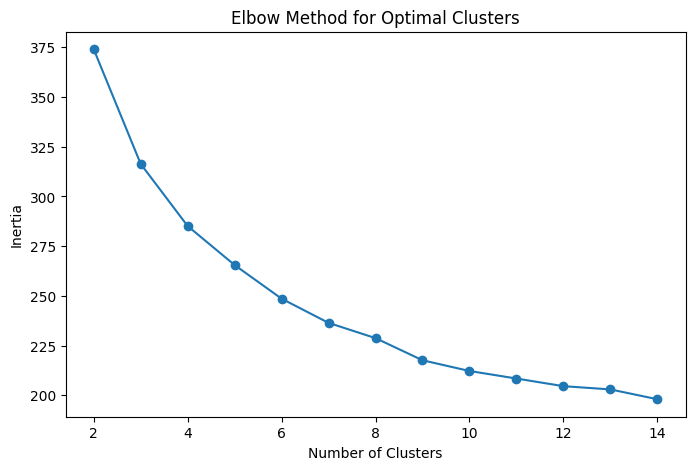

In [45]:
# To extract insights from opcode vectors, we can apply clustering techniques like KMeans
# This allows us to group similar opcode vectors and analyze differences between clusters
# By examining the characteristics of each cluster, 
# we can uncover patterns or distinctions that may correlate with malicious or clean contract behavior

vectors_arr = np.asarray(tfidf_dense)

inertia = []
range_n_clusters = range(2, 15)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(vectors_arr)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


-	Based on the embedding vectors, the optimal number of clusters appears to be either 4 (5) or 9.
-	For simplicity, I will proceed with 3 clusters, which matches the label cardinality, and analyze them.
-	My assumption is that clustering will reveal distinctions between clean and malicious contracts, assigning them to different clusters.
-	If this assumption holds, it would confirm a statistical difference in the opcodes of malicious and clean contracts, validating the use of embedding and statistical techniques to extract descriptive insights from the code.

In [46]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_arr)

In [47]:
opcode_emb = opcode_emb.with_columns(
    pl.Series(name='opcode_emb_cluster', values=cluster_labels)
)
opcode_emb.head()

address,chain_id,bytecode,opcode,malicious_category_l1,malicious_category_l2,data_source,man_validated,man_validated_by,comment,label,opcode_embedding,opcode_emb_cluster
str,i64,str,str,str,str,str,bool,str,str,str,"array[f64, 58747]",i32
"""0xc9d7bd1fad7d5621dda20335818e…",1,"""0x6080604052600436106103fe5760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]",0
"""0x357d4db0c2179886334cc33b8528…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.008558, … 0.0]",0
"""0x5954ab967bc958940b7eb73ee847…",1,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""White_Lists""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]",0
"""0x5c9ad7b877f06e751ee006a3f275…",43114,"""0x6080604052600436106100955760…","""PUSH1 PUSH1 MSTORE PUSH1 CALLD…","""Cyber""","""Exploit""","""Public_Historical_Data""",false,null,"""Data additionally gathered fro…","""Exploit""","[0.0, 0.0, … 0.0]",1
"""0x7a720b4f627b9e6f688023f4f2cc…",137,"""0x6080604052348015610010576000…","""PUSH1 PUSH1 MSTORE CALLVALUE D…",null,null,"""Random_Data""",false,null,null,"""Clean""","[0.0, 0.0, … 0.0]",1


In [48]:
opcode_emb['opcode_emb_cluster'].value_counts()

opcode_emb_cluster,count
i32,u32
2,131
1,1288
0,2504


In [49]:
opcode_emb.group_by('label').agg(
    pl.col('opcode_emb_cluster').mode().alias('cluster_mode'),
    pl.col('opcode_emb_cluster').mean().alias('cluster_mean')
)

label,cluster_mode,cluster_mean
str,list[i32],f64
"""FinancialScam""",[1],0.735
"""Exploit""",[1],0.681948
"""Clean""",[0],0.345287


- So, even with simple vectorization and clustering techniques, the cluster labels differ between clean and malicious contracts, indicating a meaningful distinction in their code.
- This is a promising result, showing that clean and malicious contract codes are inherently different.
- To improve further, we could experiment with more advanced embedding and clustering methods, such as:
    - Pre-Trained Language Models for Code (e.g., CodeBERT, GraphCodeBERT).
    - A custom Opcode2Vec model, trained on our data using a Word2Vec-like architecture.
    - A custom OpcodeLSTM, though this is resource-intensive.
- Additionally, we could incorporate the cluster labels as a feature or engineer other features derived from the embeddings to enhance model performance.

# Next steps

The overall logic for preparing the dataset and generating features will follow similar steps to those described earlier:
1.	Data Cleaning
-	As mentioned, there are issues with transcribing contract bytecode into opcodes (e.g., unrecognized tokens). These problems should be clarified, and affected entries either fixed or removed from the dataset.
2.	Feature Engineering
-	While the earlier steps provide a basic outline, it’s clear that feature engineering requires more time and experimentation. Potential feature ideas include:
    -	Identifying whether a contract with the same bytecode already exists on other blockchains.
    -	Calculating similarity metrics between bytecodes.
    -	Generating more extensive statistical features from the code.
    -	Improving embedding features by experimenting with different models, such as those described earlier (e.g., Pre-Trained Language Models or Opcode2Vec).
    -	More complex and domain-specific features should also be explored for better predictive performance.
3.	Data Normalization
-	For tree-based models like XGBoost or LightGBM, normalization is not required. Simply marking categorical features is sufficient, as these models handle normalization internally.
-	For simpler models like Logistic Regression or Random Forests, normalizing features and encoding categorical ones using OneHotEncoder is essential for optimal performance.

### Further Research

1.	Exploring Contract Code
-   Investigate clustering contract codes using algorithms such as KMeans, DBSCAN, or hierarchical clustering to identify main patterns or group similar contracts.
-   Experiment with anomaly detection algorithms (e.g., Isolation Forest or One-Class SVM) to identify outliers in the code.
-   Add more features that describe the code, such as more specific entropy, opcode frequency distributions, or the presence of specific sequences of opcodes.
-   Explore generating higher-level abstractions from bytecode. For example:
	-   Translating bytecode into a pseudo-language or higher-level representations.
	-   Leveraging program analysis techniques to extract control-flow or data-flow information.
-   Evaluate sophisticated embedding techniques (e.g., Pre-Trained Language Models like CodeBERT) to create more meaningful and context-aware representations of contract code.
2.	Exploring the Impact of Different Blockchains
-   Calculate and compare statistics for different blockchains to understand how they vary in terms of:
	-   Code quality.
	-   Opcode usage patterns.
	-   The prevalence of malicious contracts.
-   Investigate if certain blockchains are more prone to vulnerabilities or specific malicious activities.
-   Analyze if differences are driven by blockchain policies, technical limitations, or specific use cases.	
3.	Investigating Temporal Patterns
-   Analyze the timestamps of contracts (if available) to identify trends or seasonality in malicious activities.
-   Explore whether certain opcodes or blockchain vulnerabilities are linked to specific time periods.
4. Feature Engineering for Better Code Representation
-   Experiment with combining code features (e.g., opcode frequency, clustering labels, entropy) with external features like data_source and chain_id.
-   Explore more advanced techniques like graph-based features (e.g., representing contracts as control-flow graphs) to enhance the feature set.
	
### Model Development

1.	Model Selection
-	Experiment with various models to determine the best-performing one. For example:
    -	Start with tree-based models (e.g., LightGBM, XGBoost) for high interpretability and baseline performance.
    -	Gradually experiment with more complex architectures like neural networks or transformers if necessary.
2.	Model Training
-	Optimize based on specific metrics.
-	Fix one primary metric (e.g., recall or precision) and tune the model to improve the other.
-	Experiment with hyperparameter tuning techniques (e.g., grid search or Bayesian optimization) for fine-tuning.
3.	Results Validation
-	Check for data leakage or inconsistencies in the dataset.
-	Evaluate how often the data distribution changes and its impact on model validity.
-	Compare offline metrics with online metrics to ensure consistency and identify areas for improvement.

### Deployment

1.	Performance Monitoring
-	Use frameworks like MLflow or similar tools to monitor model performance and track versions.
-	Implement monitoring for key metrics (e.g., latency, accuracy, drift) to maintain reliability.
2.	A/B Testing
-	Establish an A/B testing framework to compare the performance of new model versions with existing ones.
-	Use this process to safely roll out improvements and validate them against real-world data.